# Module import

In [1]:
import pickle
import pandas as pd
import numpy as np
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
import h5py
import warnings
warnings.filterwarnings(action='ignore')

# 1. Captioning Featured videos

## Structure of extracted features in captioning model

In [2]:
# visual info
backbone_2d_dict = {}
backbone_3d_dict = {}
objects = {}
# featured 2D(inceptionresnetv2)
with h5py.File('data/captioning/featured/MSRVTT_inceptionresnetv2.hdf5', 'r') as f:
    for vid in f.keys():
        temp_feat = f[vid][()]
        sampled_idxs = np.linspace(0, len(temp_feat) - 1, 15, dtype=int)
        backbone_2d_dict[vid] = temp_feat[sampled_idxs]
    
# featured 3D(C3D)
with h5py.File('data/captioning/featured/MSRVTT_C3D.hdf5', 'r') as f:
    for vid in f.keys():
        temp_feat = f[vid][()]
        sampled_idxs = np.linspace(0, len(temp_feat) - 1, 15, dtype=int)
        backbone_3d_dict[vid] = temp_feat[sampled_idxs]

# featured object
with h5py.File('data/captioning/featured/MSRVTT_vg_objects.hdf5', 'r') as f:
    for vid in f.keys():
        temp_feat = f[vid]['feats'][()]
        objects[vid] = temp_feat
        
        
print("=====================Visual Features=======================")
print("2D backbone(inceptionresnetv2) shape :", backbone_2d_dict['video6513'].shape)
print("3D backbone(C3D) shape :", backbone_3d_dict['video6513'].shape)
print("object(vgg) shape : ", objects['video6513'].shape)

=====================Visual Features=======================
2D backbone(inceptionresnetv2) shape : (15, 1536)
3D backbone(C3D) shape : (15, 2048)
object(vgg) shape :  (49, 2048)


In [3]:
# language index
with open("data/captioning/featured/idx2word.pkl", 'rb') as f:
    mask = pickle.load(f)
    
with open("data/captioning/featured/captions.pkl", 'rb') as f:
    captions = pickle.load(f)
    

print("=====================Language Features=======================")
print("vocabulary index(include <ios>, <eos>) :", len(mask))
print("the number of captions in video :", len(captions[list(captions.keys())[0]]))

=====================Language Features=======================
vocabulary index(include <ios>, <eos>) : 28485
the number of captions in video : 20


## Captioning info
use opensource : https://github.com/MarcusNerva/HMN

- 테스트 코드 사용
- MSR-VTT 데이터셋을 기반으로 오픈소스와 동일한 패러미터 최적화
- python==3.7, pytorch==1.4

## Result

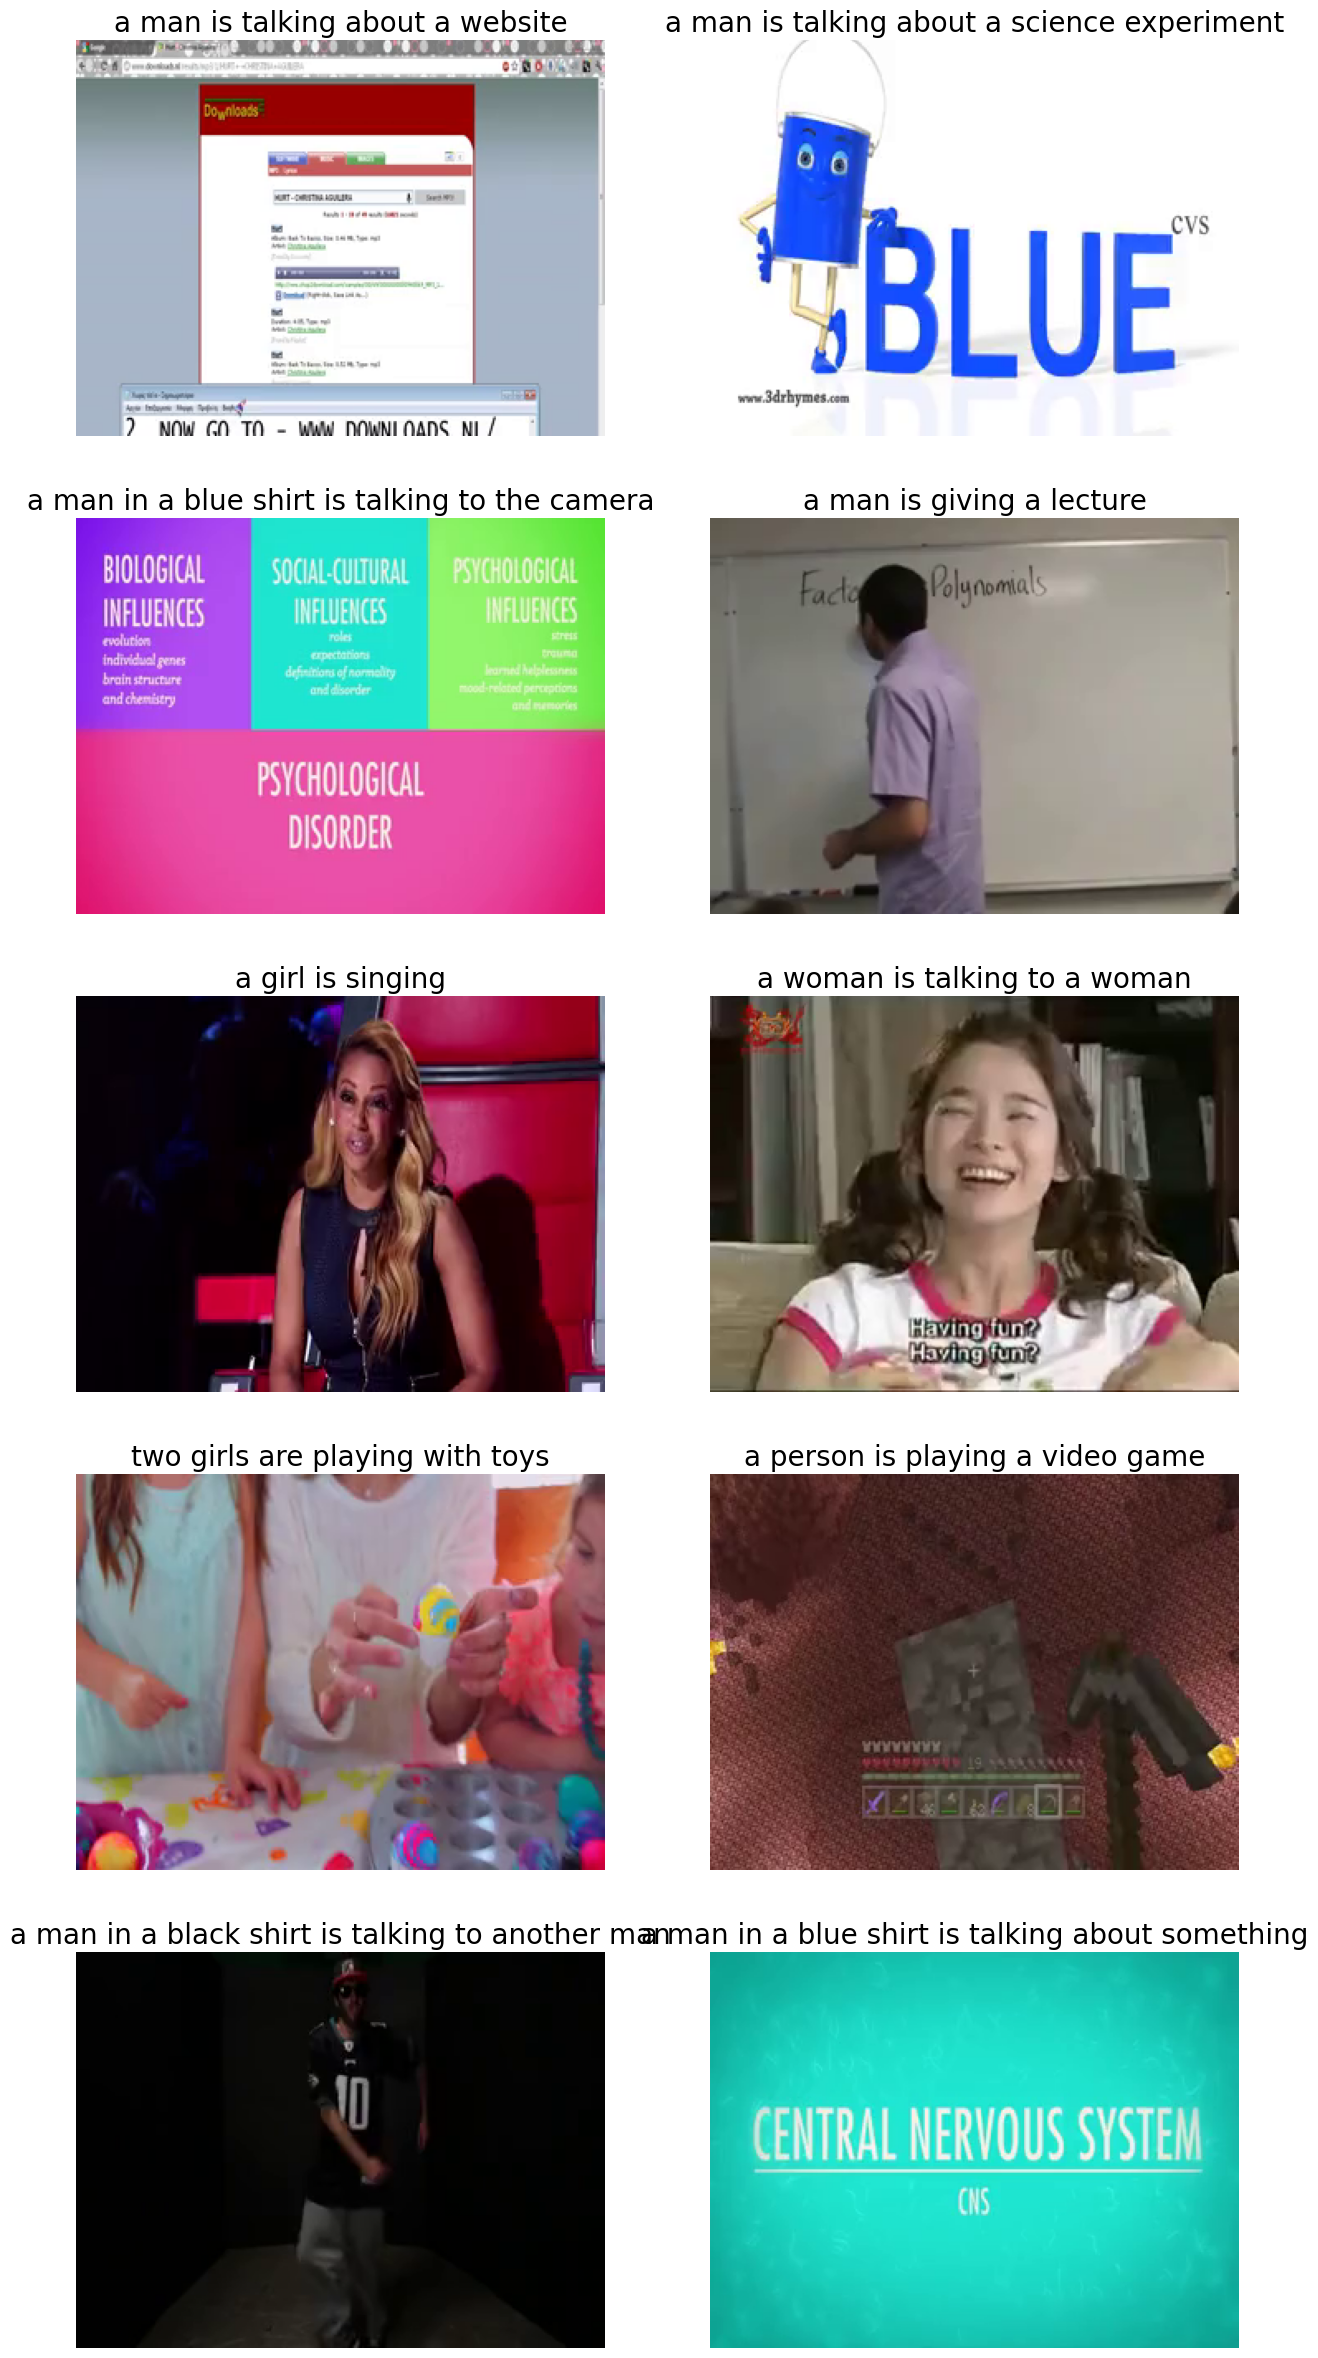

In [4]:
# captioning output
with open("data/captioning/result/captioning_result.pkl", 'rb') as f:
    c_result = pickle.load(f)
    
# sample case
lsc = list(c_result.items())
lsc[:10]
videos = []
for i in range(len(lsc[:10])):
    video_path = "data/videos/test_videos/TestVideo/" + lsc[i][0] + ".mp4"
    video = cv2.VideoCapture(video_path).read()
    videos.append({'id' : lsc[i][0], 'caption' : lsc[i][1], 'img' : video[1]})
    
fig = plt.figure(figsize = (15, 30))
rows, cols = 5, 2

font = {
    'fontsize' : 20,
    'fontweight' : 'normal'
}

for i in range(len(videos)):
    ax = fig.add_subplot(rows, cols, i+1)
    ax.imshow(cv2.cvtColor(videos[i]['img'], cv2.COLOR_BGR2RGB))
    ax.set_title(videos[i]['caption'], fontdict=font)
    ax.axis('off')

plt.show()

# 2. retrieval by captioning results

## Structure of extracted features in retrieval model

In [5]:
with open("data/retrieval/featured/MSRVTT_featured.pkl", 'rb') as f:
    r_featured = pickle.load(f)

    
    
print(f"audio spectrogram :({r_featured[0]['audio'].shape[0]}, {r_featured[0]['audio'].shape[1]})")
print(f"3D backbone features : {r_featured[0]['3d'].shape[1]}")
print(f"2D backbone features : {r_featured[0]['2d'].shape[1]}")

audio spectrogram :(40, 1106)
3D backbone features : 2048
2D backbone features : 2048


## Retrieval info

use opensource : https://github.com/ninatu/everything_at_once
- 기존 코드 및 사전학습 모델 이용
- MSR-VTT 데이터셋을 기반으로 오픈소스와 동일한 패러미터 최적화
- 검색을 위한 텍스트와 동영상 유사도를 분석할 때, captioning의 결과를 활용
- 내부의 유사도를 구하는 알고리즘 및 그 결과로 출력된 968개 테스트 데이터의 서로간의 유사도를 활용

## Preprocessing

captioning 결과를 retrieval을 위한 검색어에 추가

In [6]:
ids = []
r_featured_captioning = r_featured
for ele in r_featured_captioning:
    ele['eval_caption'] = c_result[ele['id']]
    ids.append(ele['id'])
    
with open("data/retrieval/featured/MSRVTT_caption.pkl", 'wb') as f:
    pickle.dump(r_featured_captioning, f)
    
with open("data/retrieval/featured/MSRVTT_featured.pkl", 'rb') as f:
    r_featured = pickle.load(f)
    
for i in range(5):
    print(f"{ids[i]}")
    print("label :", r_featured[i]['eval_caption'])
    print("predict :", r_featured_captioning[i]['eval_caption'])
    print("=============================================================")

video7020
label : a woman creating a fondant baby and flower
predict : a person is making a piece of paper
video7021
label : baseball player hits ball
predict : people are playing baseball
video7024
label : little pet shop cat getting a bath and washed with little brush
predict : a person is playing with a toy
video7025
label : a naked child runs through a field
predict : a man is on the beach
video7026
label : a man is giving a review on a vehicle
predict : a man is talking about a car


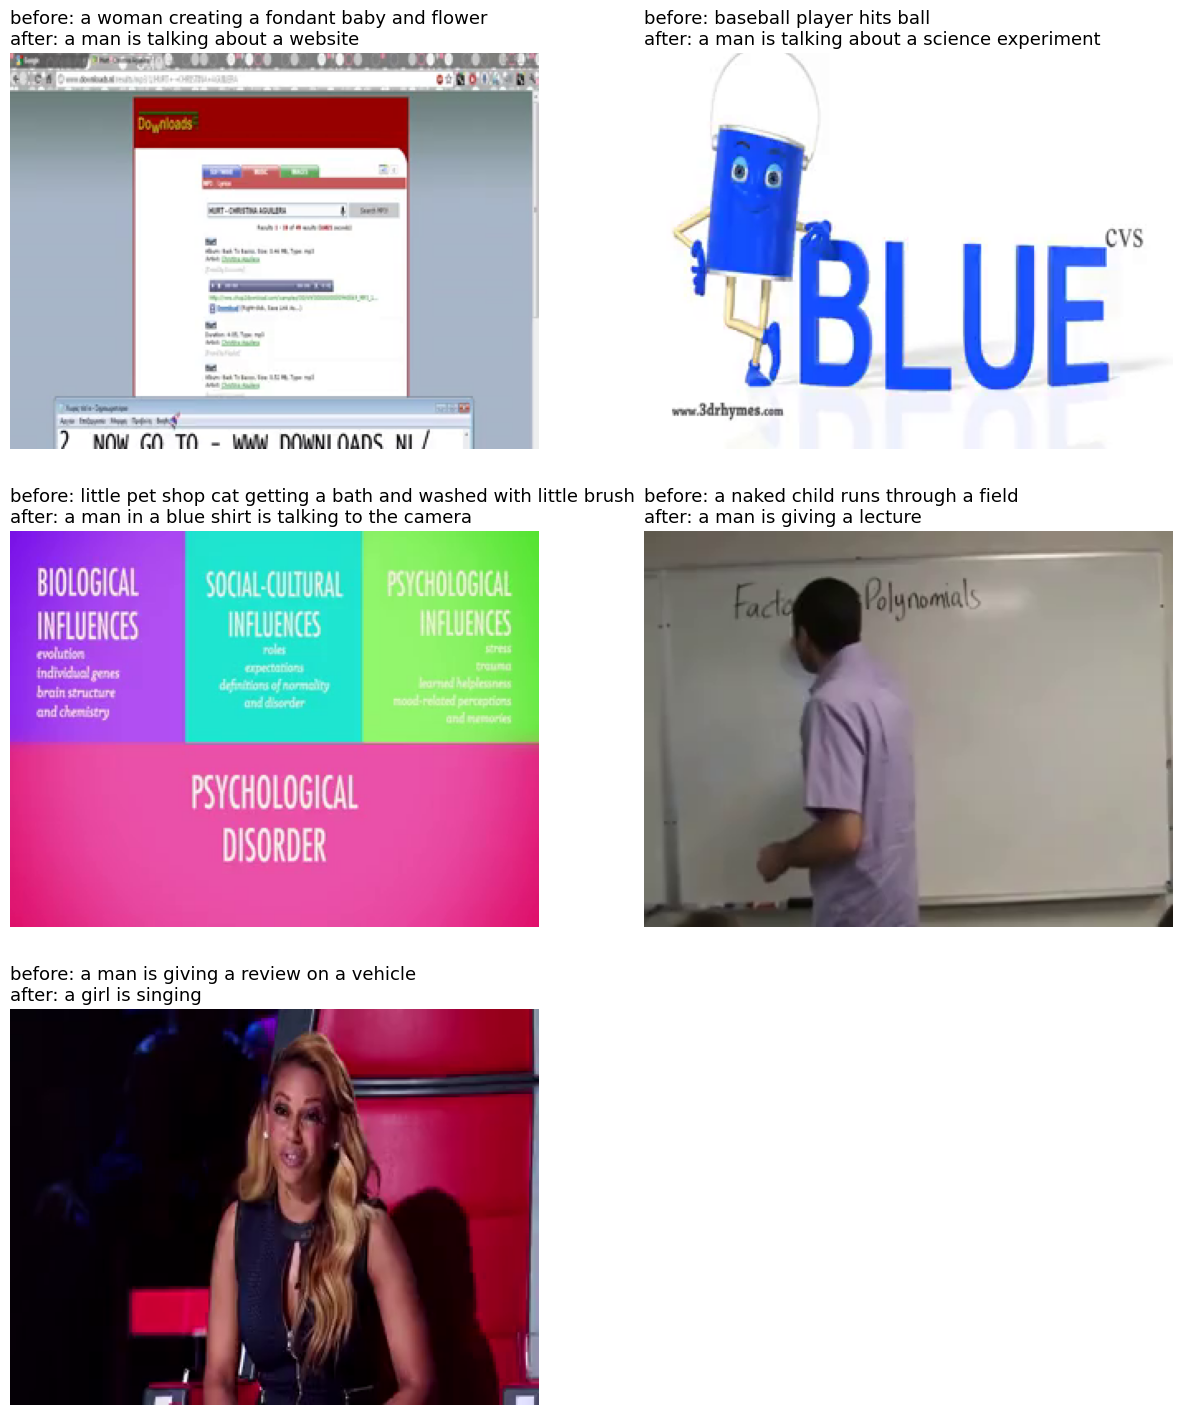

In [7]:
fig = plt.figure(figsize = (15, 30))
rows, cols = 5, 2

font = {
    'fontsize' : 13,
    'fontweight' : 'normal'
}

for i in range(5):
    ax = fig.add_subplot(rows, cols, i+1)
    ax.imshow(cv2.cvtColor(videos[i]['img'], cv2.COLOR_BGR2RGB))
    ax.set_title("before: " + r_featured[i]['eval_caption'] + '\n' + "after: " + videos[i]['caption'], fontdict=font, loc='left')
    ax.axis('off')

plt.show()

## Result

In [8]:
with open("data/retrieval/result/sim_caption.pkl", 'rb') as f:
    sim_caption = pickle.load(f)

print(sim_caption['t2v'].shape)

(968, 968)


In [9]:
t2v = pd.DataFrame(sim_caption['t2v'], index=ids, columns=ids)
t2v

video7020  video7021  video7024  video7025  video7026  video7027  \
video7020   0.001743   0.023562   0.089442   0.064106  -0.042263   0.136810   
video7021  -0.014428   0.382332   0.168053   0.257322   0.005939   0.168425   
video7024   0.062864   0.148763   0.185027   0.063717  -0.039862   0.176594   
video7025  -0.006881   0.192642   0.120589   0.293928   0.083577   0.151418   
video7026  -0.093191   0.111537   0.212854   0.130998   0.187697   0.117603   
...              ...        ...        ...        ...        ...        ...   
video9909  -0.049046   0.177371   0.201119   0.134288   0.027397   0.398857   
video9919  -0.055951   0.170352   0.221351   0.214748   0.027287   0.141992   
video9957  -0.036975   0.234880   0.114182   0.264119  -0.001318   0.178704   
video9969   0.052145   0.218707   0.116297   0.125127   0.005448   0.130459   
video9975  -0.064152   0.104400   0.140304   0.118420   0.255255   0.118759   

           video7028  video7029  video7034  video7035  ...  video9879  \
video7020   0.046964   0.169989   0.088067   0.140991  ...   0.104189   
video7021   0.214407   0.232058   0.203516   0.223945  ...   0.259317   
video7024   0.082787   0.271756   0.155573   0.209092  ...   0.140160   
video7025   0.234543   0.223440   0.133456   0.202993  ...   0.194880   
video7026   0.118072   0.153686   0.125160   0.129372  ...   0.258051   
...              ...        ...        ...        ...  ...        ...   
video9909   0.110750   0.365780   0.179286   0.404283  ...   0.189011   
video9919   0.175668   0.181715   0.130223   0.187119  ...   0.301216   
video9957   0.246029   0.260205   0.191776   0.218666  ...   0.275867   
video9969   0.110454   0.222846   0.080846   0.190093  ...   0.194168   
video9975   0.083872   0.147309   0.054178   0.123664  ...   0.195980   

           video9882  video9885  video9901  video9908  video9909  video9919  \
video7020   0.057866   0.107496   0.062000   0.184285   0.099007   0.103951   
video7021   0.140046   0.179477   0.106769   0.264193   0.243866   0.189071   
video7024   0.024950   0.085620   0.027349   0.237523   0.195198   0.114778   
video7025   0.148048   0.113768   0.028652   0.121989   0.203437   0.233350   
video7026   0.149484   0.197964   0.056872   0.116739   0.135274   0.201636   
...              ...        ...        ...        ...        ...        ...   
video9909   0.073133   0.120891  -0.023130   0.126959   0.279030   0.121866   
video9919   0.175101   0.163692   0.036279   0.160118   0.223452   0.233906   
video9957   0.127465   0.118680   0.042163   0.307892   0.329556   0.156206   
video9969   0.061368   0.078487   0.073417   0.272947   0.238802   0.079553   
video9975   0.129933   0.114033   0.086443   0.170206   0.124123   0.118242   

           video9957  video9969  video9975  
video7020   0.069115   0.059473   0.007093  
video7021   0.251100   0.121200   0.091936  
video7024   0.171599   0.238136   0.101098  
video7025   0.172792   0.064877   0.138760  
video7026   0.044115   0.069291   0.305195  
...              ...        ...        ...  
video9909   0.130384   0.152364   0.098093  
video9919   0.152599   0.120101   0.078483  
video9957   0.431580   0.201116   0.050399  
video9969   0.259191   0.239231   0.076861  
video9975   0.099368   0.086256   0.275680  

[968 rows x 968 columns]

In [10]:
# example
t2vT = t2v.transpose()
t2vT7021 = t2vT[['video7021', 'video9534', 'video8308']].sort_values('video7021', ascending=False)
t2vT7021

video7021  video9534  video8308
video9534   0.389439   0.343688   0.343688
video7021   0.382332   0.321483   0.321483
video8308   0.380764   0.424788   0.424788
video7112   0.376720   0.306568   0.306568
video7776   0.358390   0.313965   0.313965
...              ...        ...        ...
video7845  -0.035513  -0.036906  -0.036906
video7826  -0.035955  -0.035648  -0.035648
video7849  -0.044623  -0.058727  -0.058727
video7785  -0.052433  -0.077613  -0.077613
video7376  -0.053785  -0.050510  -0.050510

[968 rows x 3 columns]

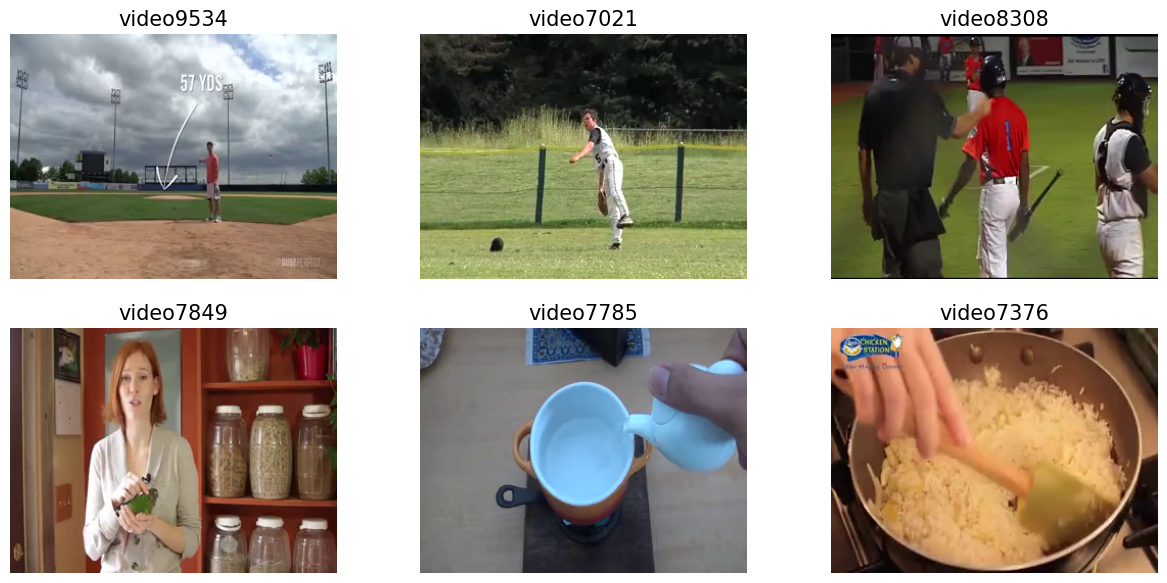

In [11]:
fig = plt.figure(figsize = (15, 7))
rows, cols = 2, 3

font = {
    'fontsize' : 13,
    'fontweight' : 'normal'
}

sim = list(t2vT7021.index[:3]) + list(t2vT7021.index[-3:])

font = {
    'fontsize' : 15,
    'fontweight' : 'normal'
}

for i in range(len(sim)):
    now = ids.index(sim[i])
    video_path = "data/videos/test_videos/TestVideo/" + sim[i] + ".mp4"
    simvideo = cv2.VideoCapture(video_path).read()
    ax = fig.add_subplot(rows, cols, i+1)
    ax.imshow(cv2.cvtColor(simvideo[1], cv2.COLOR_BGR2RGB))
    ax.set_title(sim[i], fontdict=font)
    ax.axis('off')

plt.show()

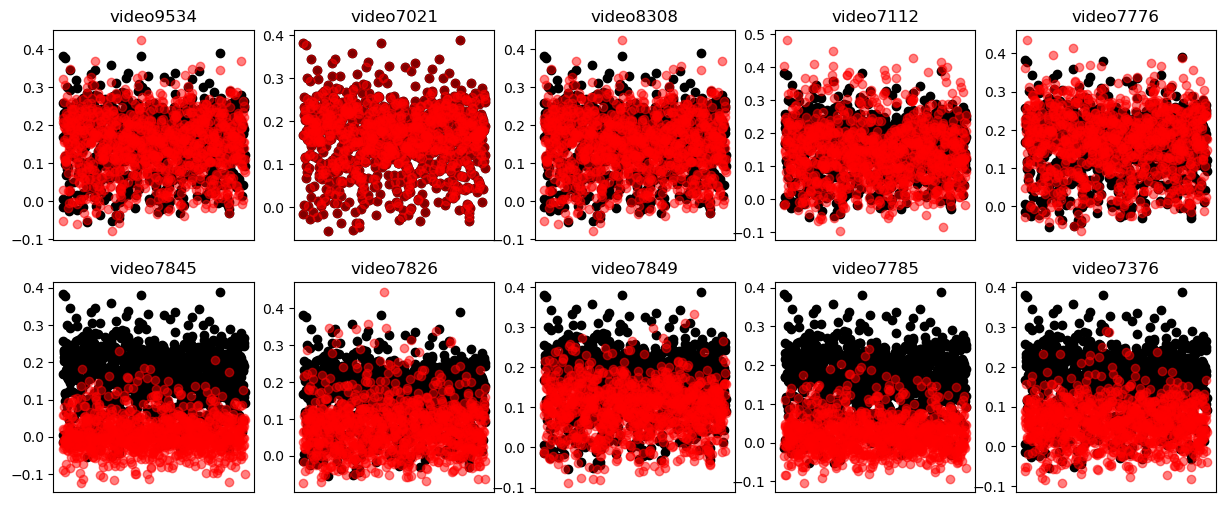

In [12]:
test= t2vT[list(t2vT7021.index[:5]) + list(t2vT7021.index[-5:])]
fig = plt.figure(figsize = (15, 6))
rows, cols = 2, 5

for i in range(len(test.columns)):
    ax = fig.add_subplot(rows, cols, i+1)
    ax.scatter(range(len(t2v)),t2v.transpose()['video7021'], color='black')
    ax.scatter(range(len(t2v)),t2v.transpose()[test.columns[i]], alpha=0.5, color='red')
    ax.set_title(test.columns[i])
    ax.xaxis.set_visible(False)
#     ax.axis('off')

plt.show()

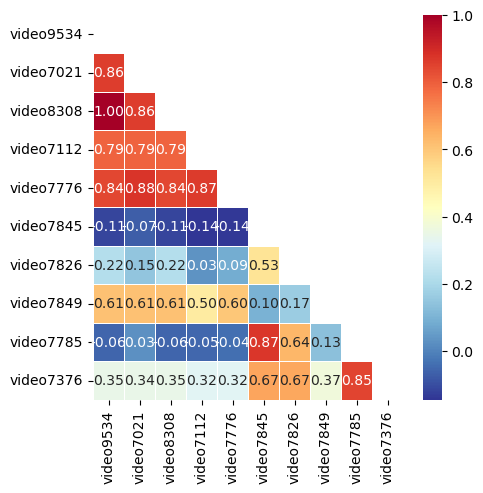

In [13]:
# 각 변수들간의 피어슨 상관계수 출력
def visualize_corr(df):
    plt.figure(figsize=(5, 5))

    mask = np.zeros_like(df.corr(), dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    sns.heatmap(data=df.corr(),
                cmap='RdYlBu_r',
                mask=mask,
                annot=True, fmt='.2f',
                linewidth=.5)
    plt.show()
    
sample = t2vT[list(t2vT7021.index[:5]) + list(t2vT7021.index[-5:])]
visualize_corr(sample)

# 3. Similarity based video filtering

In [14]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(min_samples=3, eps=2.5)

clusters = dbscan.fit_predict(t2vT.corr())

In [15]:
clusters.max()

30

In [16]:
cls = {}
for i in range(clusters.min(), clusters.max()+1):
    cls[i] = []

for i in range(len(clusters)):
    cls[clusters[i]].append(ids[i])

len(cls[-1])

79

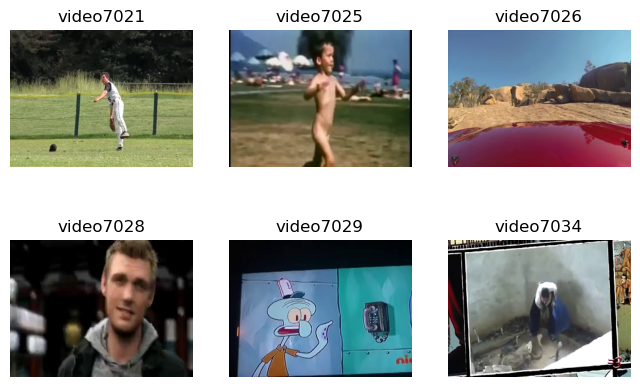

In [17]:
# sample case
videos = []
tc = 1
for i in range(min(len(cls[tc]), 6)):
    video_path = "data/videos/test_videos/TestVideo/" + cls[tc][i] + ".mp4"
    video = cv2.VideoCapture(video_path).read()
    videos.append({'id' : cls[tc][i], 'img' : video[1]})
    
fig = plt.figure(figsize = (8, 5))
rows, cols = 2, 3

for i in range(min(len(videos), 6)):
    ax = fig.add_subplot(rows, cols, i+1)
    ax.imshow(cv2.cvtColor(videos[i]['img'], cv2.COLOR_BGR2RGB))
    ax.set_title(videos[i]['id'])
    ax.axis('off')

plt.show()

In [18]:
party = {"id" : [], "caption" : []}
for i in range(len(cls[tc])):
    now = ids.index(cls[tc][i])
    party['id'].append(cls[tc][i])
    party['caption'].append(r_featured_captioning[now]['eval_caption'])

df = pd.DataFrame(party)
df

id                                            caption
0    video7021                        people are playing baseball
1    video7025                              a man is on the beach
2    video7026                       a man is talking about a car
3    video7028                       a man is talking to a camera
4    video7029                          someone is playing a game
..         ...                                                ...
573  video9882           a woman is being interviewed on the news
574  video9885                       a man is talking to a camera
575  video9901  a man with glasses is talking in front of a ca...
576  video9919                        a man is talking to a woman
577  video9957                      a group of people are dancing

[578 rows x 2 columns]